In [4]:
import numpy as np
import pandas as pd
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
import matplotlib.pyplot as pltp
import os
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
import seaborn as sns

In [5]:
import random # 设置全局随机种子 
def set_global_seed(seed_value): 
    random.seed(seed_value) # 设置Python随机种子 
    np.random.seed(seed_value) # 设置NumPy随机种子 
set_global_seed(2606)

In [6]:
data = pd.read_csv(r"D:\论文数据\2025.2 出口选择\20190519+问卷统计表.csv", encoding='utf-8') 

In [7]:
rename_dict = {
    '性别': 'Gen',
    '年龄段': 'Age',
    '教育程度': 'Edu',
    '行动能力': 'Mob',
    '您乘坐客船的经历（不含本次）': 'PCE',
    '与您一起出行的人员数量': 'GS',
    '接受船舶疏散教育/训练的经历': 'ET',                     
    '听到疏散逃生警报，您会等待工作人员确认后再行动': 'WFS',
    '听到疏散逃生警报，您会立即疏散逃生': 'EI',
    '听到疏散逃生警报，您会观察其他人的动静再行动': 'OO',
    '假如听到疏散逃生警报，您会自行开门查看确认': 'CBS',      
    '疏散逃生时，您会选择距离最近的出口': 'NE',  #
    '疏散逃生时，您会选择最熟悉的出口': 'FE',  #
    '疏散逃生时，您会选择跟着大多数人走': 'FM',  #
    '疏散逃生时，您会选择听从疏散指示或广播': 'FI',  #       
    '您会耐心排队等待': 'WIQ',
    '您会自行寻找其他出口': 'FOE',  
    '您会往前挤行': 'PF',
    '您会听从船员引导': 'FS',
    '贵重物品遗留，您是否会返回寻找': 'RFV',
    '家人遗留，您是否会返回寻找': 'RFF',
    '疏散过程中，您是否会协助他人进行疏散': 'HO',
    '疏散过程中，您是否会超越他人或向前挤行': 'OtO',
    '疏散逃生时，您是否会寻找同伴一起逃生': 'FC',
    '假如发生火灾，您是否会出现恐慌心理': 'PDF',
    '疏散时，您是否会携带大件行李箱': 'CL',
    '疏散时，您是否会跟从团队中的临时领导者': 'FL'
}
data.rename(columns=rename_dict, inplace=True)

In [8]:
data = data.drop('序号', axis=1)
df = pd.DataFrame(data.values - 1, columns=data.columns)

In [9]:
print(df.columns)

Index(['Gen', 'Age', 'Edu', 'Mob', 'PCE', 'GS', 'ET', 'WFS', 'EI', 'OO', 'CBS',
       'NE', 'FE', 'FM', 'FI', 'WIQ', 'FOE', 'PF', 'FS', 'RFV', 'RFF', 'HO',
       'OtO', 'FC', 'PDF', 'CL', 'FL'],
      dtype='object')


In [10]:
df

,Gen,Age,Edu,Mob,PCE,GS,ET,WFS,EI,OO,...,PF,FS,RFV,RFF,HO,OtO,FC,PDF,CL,FL
0,1,3,1,4,3,3,0,4,4,3,...,4,2,3,3,2,4,2,3,4,3
1,1,6,0,0,1,1,0,3,4,3,...,1,2,3,4,3,2,4,2,3,3
2,1,6,1,1,2,2,0,2,3,4,...,1,4,3,2,4,2,2,4,3,2
3,1,6,0,1,2,3,0,3,3,4,...,4,3,2,2,3,4,3,3,4,3
4,1,5,0,1,2,2,0,4,4,3,...,3,4,2,4,3,4,2,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,1,5,0,2,2,2,0,4,0,2,...,0,4,4,4,2,0,2,3,0,3
1376,1,3,1,3,1,1,0,4,2,3,...,0,4,4,4,3,0,3,2,0,3
1377,0,4,1,2,2,2,1,3,2,3,...,0,4,4,4,3,0,3,2,0,3
1378,1,4,0,2,2,1,0,3,3,2,...,0,3,4,4,2,0,4,1,0,3


In [11]:
# 前部变量（行为与心理因素）
front_vars = ['Gen', 'Age', 'Edu', 'Mob', 'PCE', 'GS', 'ET', 
              'WFS', 'EI', 'OO', 'CBS', 'WIQ', 'PF', 'FS', 
              'RFV', 'RFF', 'HO', 'OtO', 'FC', 'PDF', 'CL', 'FL', 'FOE']

# 后部变量（出口选择行为）
exit_vars = ['NE', 'FE', 'FM', 'FI',]

   Variable        Impact    Net_Impact
5        GS  1.731741e+06  0.000000e+00
0       Gen  1.466894e+06  9.313226e-10
3       Mob  1.417958e+06  2.793968e-09
4       PCE  1.413508e+06 -5.820766e-10
1       Age  1.284220e+06 -3.259629e-09
6        ET  9.294517e+05 -1.280569e-09
2       Edu  8.223237e+05  7.566996e-10
7       WFS  5.752701e+05  9.313226e-10
19      RFV  4.529077e+05  5.820766e-10
14       FI  3.479586e+05 -9.313226e-10
11       NE  3.442354e+05 -7.566996e-10
10      CBS  1.650522e+05  1.207809e-09
15      WIQ  1.568574e+05 -3.346941e-10
18       FS  6.409721e+04  4.438334e-09
12       FE  2.111882e+04  9.622454e-10
25       CL  3.267393e+01 -2.913580e-11
23       FC  1.331889e+01  2.495781e-12
26       FL -5.420177e+01  1.390532e-11
22      OtO -6.607062e+01 -6.820500e-11
24      PDF -1.098701e+02 -5.364598e-12
13       FM -6.575233e+02 -1.032276e-10
9        OO -6.307619e+04 -2.728484e-09


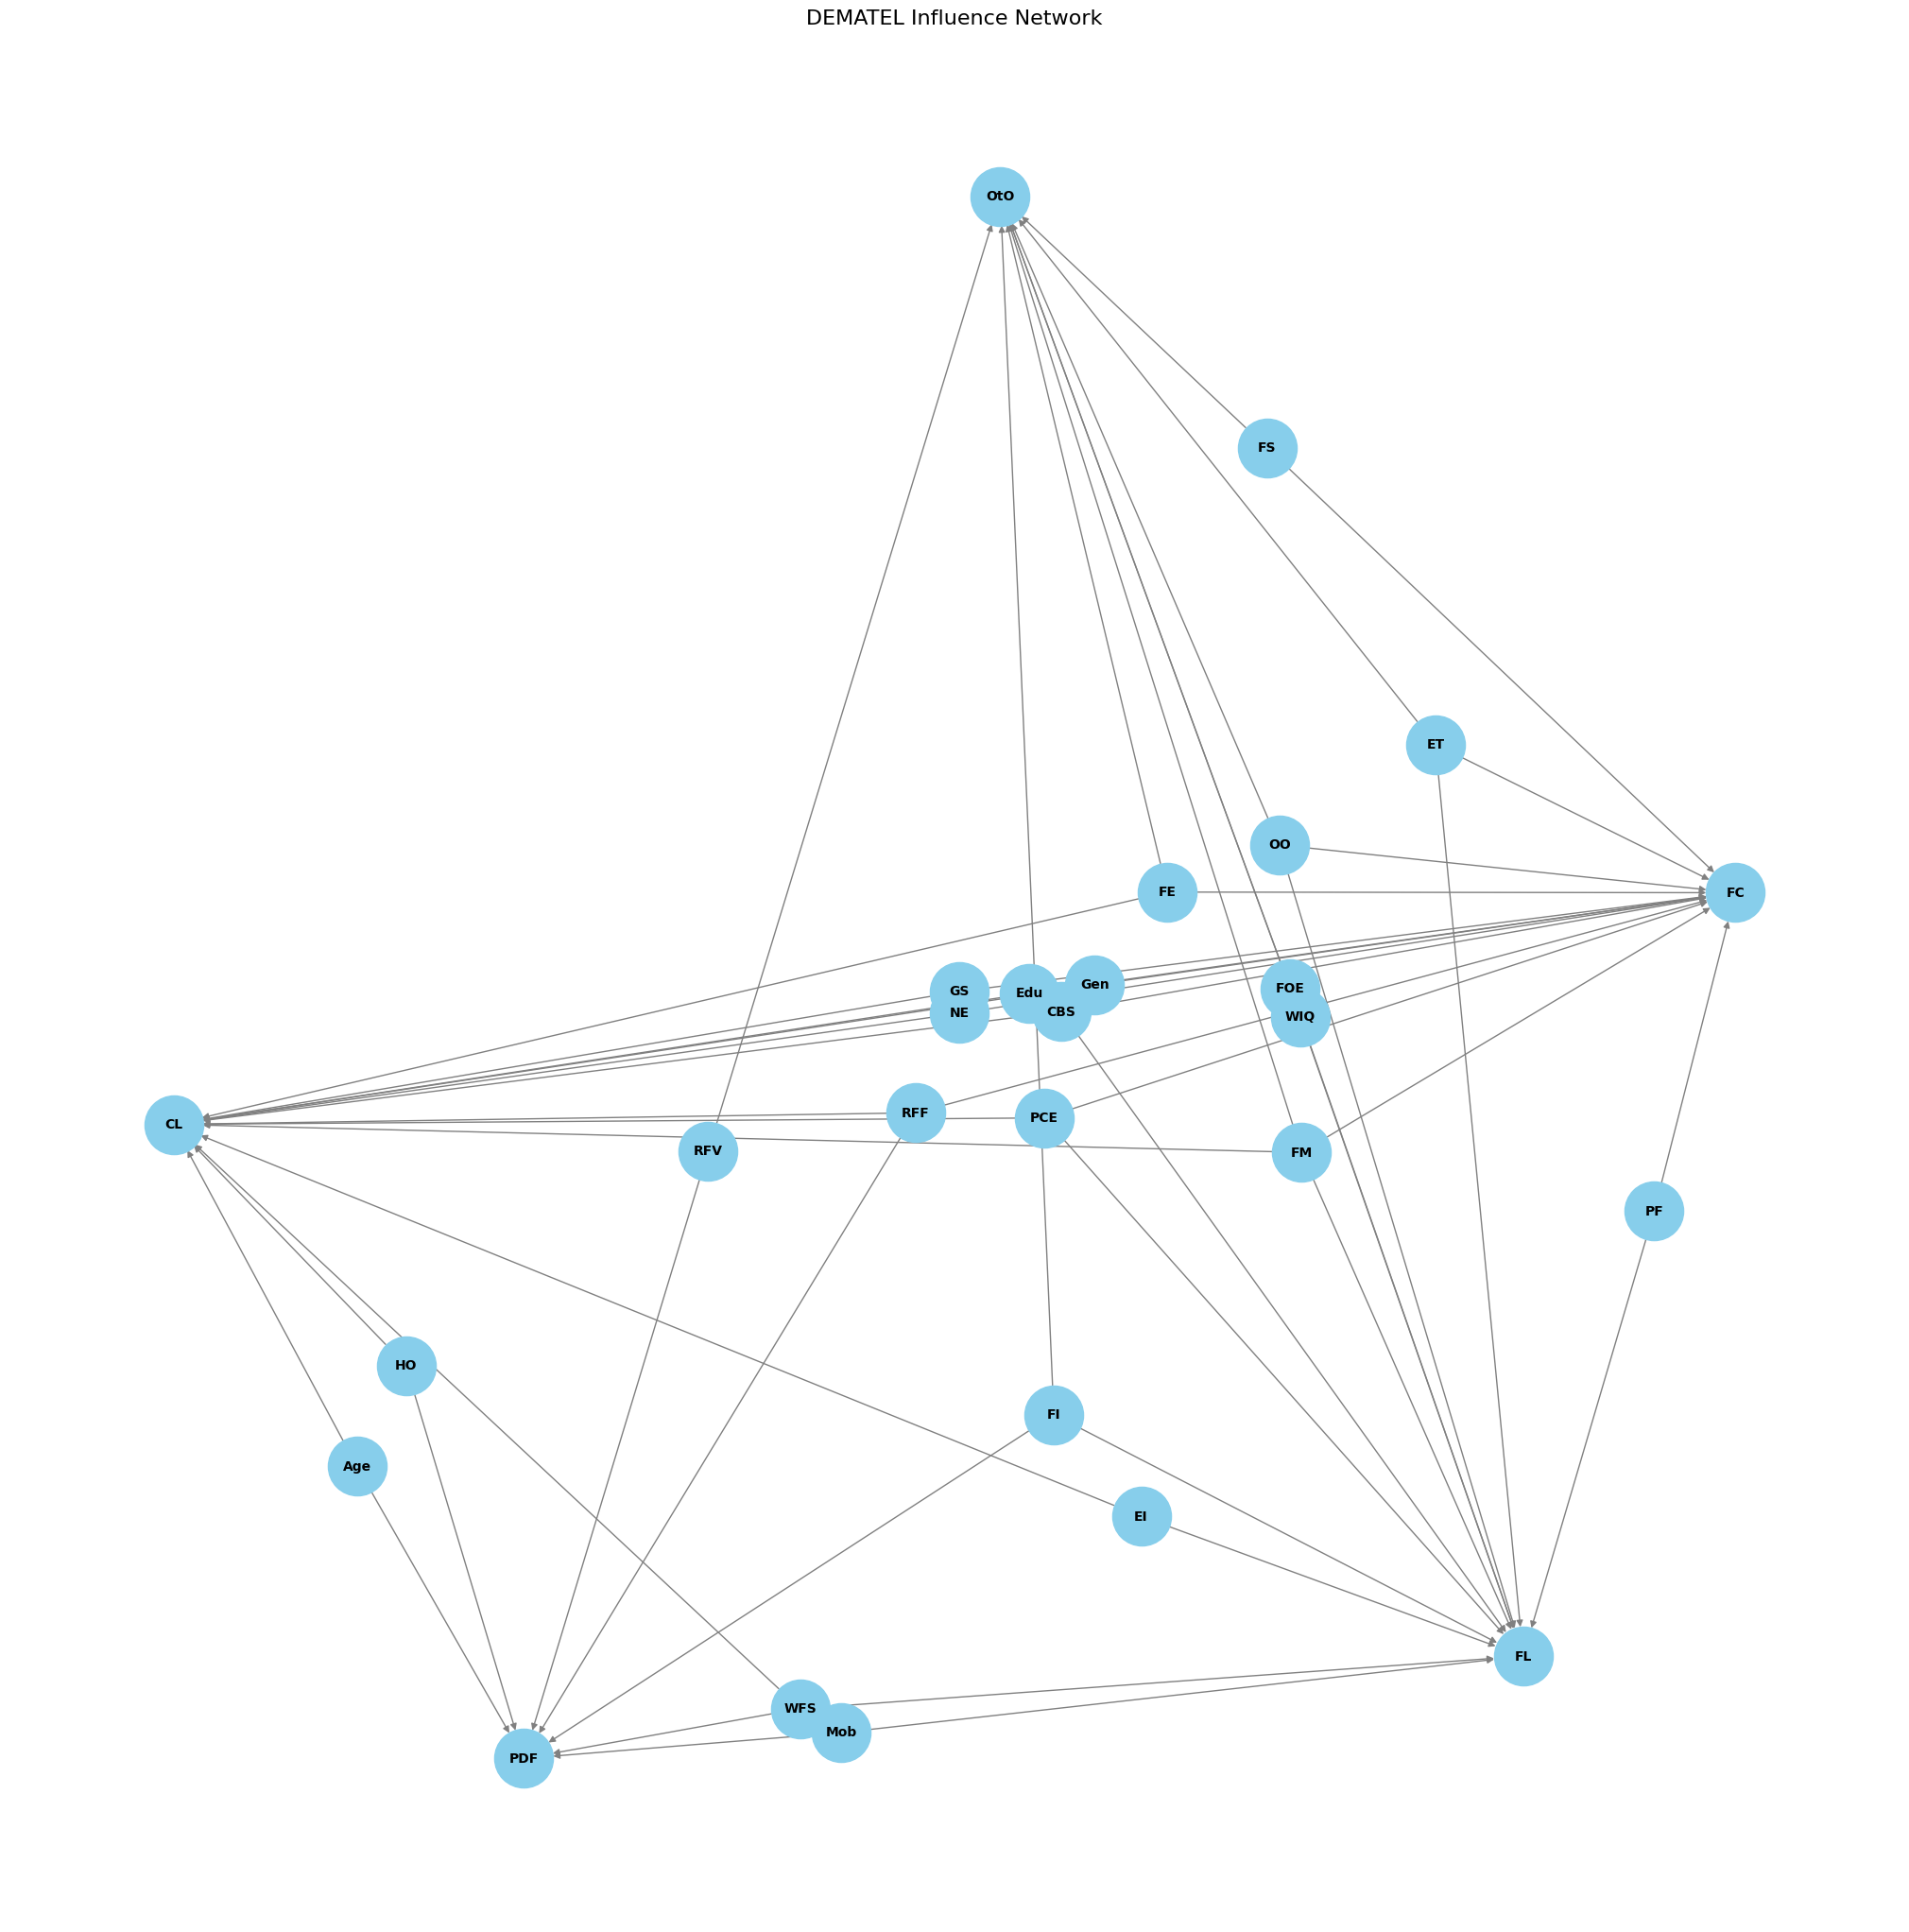

In [46]:
# 假设 df 是你的数据框
# front_vars = df.columns[:22]  # 假设前22列是前部变量
# exit_vars = df.columns[22:]  # 假设后5列是后部变量

# 初始化一个影响矩阵 D，大小为 22x5（前部变量数 x 后部变量数）
D = np.zeros((len(front_vars), len(exit_vars)))

# 填充影响矩阵 D，按每个前部变量与后部变量的关系计算影响程度
for i, front_var in enumerate(front_vars):
    for j, exit_var in enumerate(exit_vars):
        # 计算前部变量与后部变量之间的相关性
        correlation = df[front_var].corr(df[exit_var])  # Pearson 相关系数
        D[i, j] = abs(correlation)  # 取绝对值以表示影响的强度

# 归一化影响矩阵
D_norm = D / np.sum(D)

# 创建一个方阵，将前部变量和后部变量的影响矩阵合并
D_expanded = np.zeros((len(front_vars) + len(exit_vars), len(front_vars) + len(exit_vars)))

# 将 D_norm 填入前部变量与后部变量的影响区域
D_expanded[:len(front_vars), len(front_vars):] = D_norm
D_expanded[len(front_vars):, :len(front_vars)] = D_norm.T

# 设置对角线为1，表示每个变量对自身的影响
np.fill_diagonal(D_expanded, 1)

# 添加一个小的正则化项，防止矩阵不可逆
lambda_identity = 1e-6 * np.eye(D_expanded.shape[0])

# 计算总影响矩阵 T
I = np.eye(D_expanded.shape[0])  # 创建一个新的单位矩阵
T = np.linalg.inv(I - D_expanded + lambda_identity) @ D_expanded  # 计算总影响矩阵

# 计算行和 R 和列和 C
R = np.sum(T, axis=1)  # 影响度
C = np.sum(T, axis=0)  # 受影响度

# 计算 R + C (总影响力) 和 R - C (净影响力)
impact = R + C
net_impact = R - C

# 将结果存入数据框
result = pd.DataFrame({
    'Variable': list(front_vars) + list(exit_vars),
    'Impact': impact,
    'Net_Impact': net_impact
})

# 按照总影响力排序
result_sorted = result.sort_values(by='Impact', ascending=False)

# 打印前15个影响最大的因素
top_22 = result_sorted.head(22)
print(top_22)

# 输出结果到指定目录
output_dir = r'D:\论文数据\2025.2 出口选择\因素分析'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存影响关系数据到 CSV 文件
result_sorted.to_csv(os.path.join(output_dir, 'influence_analysis.csv'), index=False)

# 可视化影响关系图
G = nx.DiGraph()
for i in range(len(front_vars)):
    for j in range(len(exit_vars)):
        if T[i, j + len(front_vars)] > 0.1:  # 设置阈值，仅显示影响较大的关系
            G.add_edge(front_vars[i], exit_vars[j], weight=T[i, j + len(front_vars)])

# 绘制网络图
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title('DEMATEL Influence Network', fontsize=16)

# 保存网络图为图像文件
plt.savefig(os.path.join(output_dir, 'influence_network.png'), dpi=300, bbox_inches='tight')
plt.show()

# 保存影响关系数据为方便 Visio 绘图的 CSV 文件
edges = pd.DataFrame([(u, v, d['weight']) for u, v, d in G.edges(data=True)], columns=['Source', 'Target', 'Weight'])
edges.to_csv(os.path.join(output_dir, 'influence_edges.csv'), index=False)

   Variable        Impact    Net_Impact
5        GS  1.731741e+06  0.000000e+00
0       Gen  1.466894e+06  9.313226e-10
3       Mob  1.417958e+06  2.793968e-09
4       PCE  1.413508e+06 -5.820766e-10
1       Age  1.284220e+06 -3.259629e-09
6        ET  9.294517e+05 -1.280569e-09
2       Edu  8.223237e+05  7.566996e-10
7       WFS  5.752701e+05  9.313226e-10
19      RFV  4.529077e+05  5.820766e-10
14       FI  3.479586e+05 -9.313226e-10
11       NE  3.442354e+05 -7.566996e-10
10      CBS  1.650522e+05  1.207809e-09
15      WIQ  1.568574e+05 -3.346941e-10
18       FS  6.409721e+04  4.438334e-09
12       FE  2.111882e+04  9.622454e-10
25       CL  3.267393e+01 -2.913580e-11
23       FC  1.331889e+01  2.495781e-12
26       FL -5.420177e+01  1.390532e-11
22      OtO -6.607062e+01 -6.820500e-11
24      PDF -1.098701e+02 -5.364598e-12
13       FM -6.575233e+02 -1.032276e-10
9        OO -6.307619e+04 -2.728484e-09


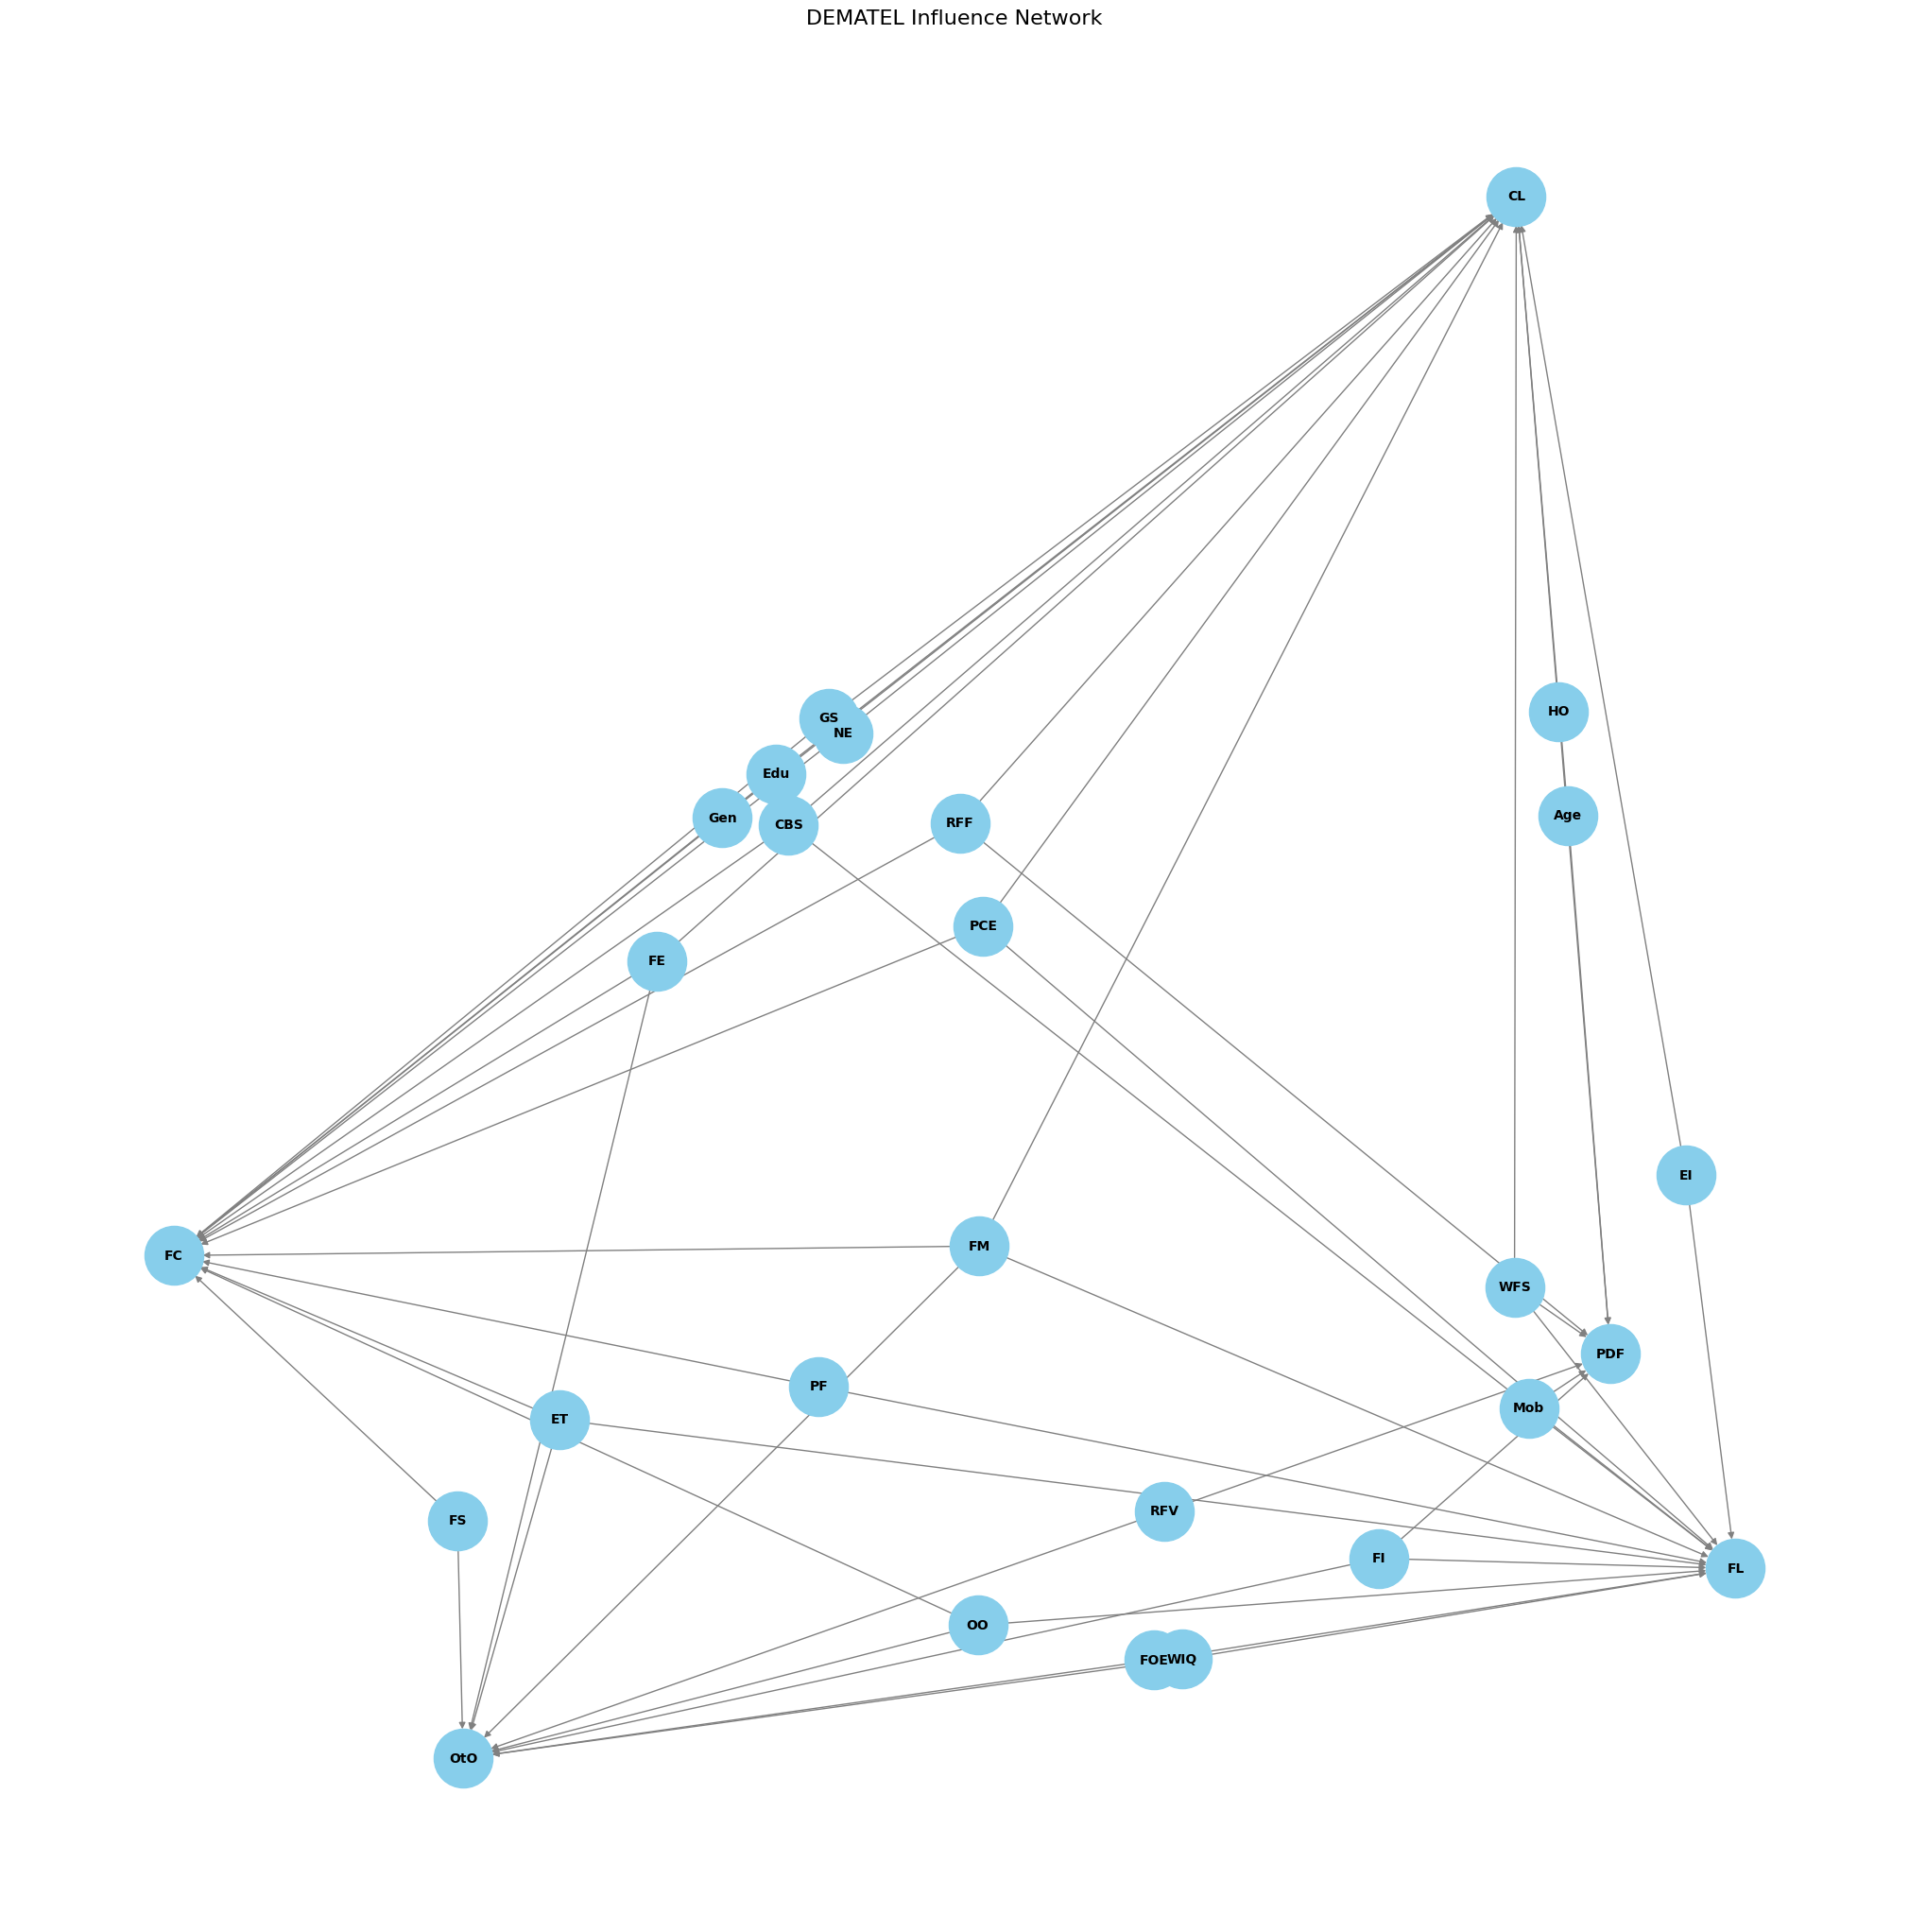

In [44]:
front_vars = df.columns[:22]  # 假设前22列是前部变量

# 后部变量（出口选择行为）
exit_vars = df.columns[22:]  # 假设后5列是后部变量

# 初始化一个影响矩阵 D，大小为 22x5（前部变量数 x 后部变量数）
D = np.zeros((len(front_vars), len(exit_vars)))

# 填充影响矩阵 D，按每个前部变量与后部变量的关系计算影响程度
for i, front_var in enumerate(front_vars):
    for j, exit_var in enumerate(exit_vars):
        # 计算前部变量与后部变量之间的相关性
        correlation = df[front_var].corr(df[exit_var])  # Pearson 相关系数
        D[i, j] = abs(correlation)  # 取绝对值以表示影响的强度

# 归一化影响矩阵
D_norm = D / np.sum(D)

# 创建一个方阵，将前部变量和后部变量的影响矩阵合并
D_expanded = np.zeros((len(front_vars) + len(exit_vars), len(front_vars) + len(exit_vars)))

# 将 D_norm 填入前部变量与后部变量的影响区域
D_expanded[:len(front_vars), len(front_vars):] = D_norm
D_expanded[len(front_vars):, :len(front_vars)] = D_norm.T

# 设置对角线为1，表示每个变量对自身的影响
np.fill_diagonal(D_expanded, 1)

# 添加一个小的正则化项，防止矩阵不可逆
lambda_identity = 1e-6 * np.eye(D_expanded.shape[0])

# 计算总影响矩阵 T
I = np.eye(D_expanded.shape[0])  # 创建一个新的单位矩阵
T = np.linalg.inv(I - D_expanded + lambda_identity) @ D_expanded  # 计算总影响矩阵

# 计算行和 R 和列和 C
R = np.sum(T, axis=1)  # 影响度
C = np.sum(T, axis=0)  # 受影响度

# 计算 R + C (总影响力) 和 R - C (净影响力)
impact = R + C
net_impact = R - C

# 将结果存入数据框
result = pd.DataFrame({
    'Variable': list(front_vars) + list(exit_vars),
    'Impact': impact,
    'Net_Impact': net_impact
})

# 按照总影响力排序
result_sorted = result.sort_values(by='Impact', ascending=False)

# 打印前15个影响最大的因素
top_22 = result_sorted.head(22)
print(top_22)

# 可视化影响关系图
G = nx.DiGraph()
for i in range(len(front_vars)):
    for j in range(len(exit_vars)):
        if T[i, j + len(front_vars)] > 0.1:  # 设置阈值，仅显示影响较大的关系
            G.add_edge(front_vars[i], exit_vars[j], weight=T[i, j + len(front_vars)])

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title('DEMATEL Influence Network', fontsize=16)
plt.show()

In [57]:
front_df = df[front_vars]
exit_df = df[exit_vars]

# 标准化前部变量
scaler = StandardScaler()
front_scaled = scaler.fit_transform(front_df)

# PCA降维，保留5个主成分
pca = PCA(n_components=5)
front_pca = pca.fit_transform(front_scaled)

# 进行回归分析，以NE为目标变量
X = front_pca
y = exit_df['FE']

# 线性回归模型
model = LinearRegression()
model.fit(X, y)

# 获取PCA后的主成分系数
coefficients = model.coef_

# 映射PCA系数到前部变量
# 这里我们假设前部变量的影响通过每个主成分的系数来加权
pca_coefficients = pca.components_.T @ coefficients  # 将PCA的主成分权重与回归系数结合

# 输出每个前部变量的加权影响
coeff_df = pd.DataFrame({'Variable': front_vars, 'Coefficient': pca_coefficients})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

# 显示影响最显著的前20个变量
top_20_vars = coeff_df.head(20)
print(top_20_vars)

   Variable  Coefficient
9        OO     0.133195
8        EI     0.129117
7       WFS     0.127810
10      CBS     0.122069
11      WIQ     0.094818
13       FS     0.080082
1       Age     0.063495
18       FC     0.057136
15      RFF     0.048348
4       PCE     0.046903
16       HO     0.043212
5        GS     0.038160
14      RFV     0.035380
19      PDF     0.034781
21       FL     0.014154
6        ET     0.013400
0       Gen     0.002118
12       PF    -0.002916
3       Mob    -0.006096
2       Edu    -0.017147


# 互信息理论

In [25]:
# 计算互信息
mi_scores = {}
for exit_var in exit_vars:
    mi = mutual_info_classif(df[front_vars], df[exit_var], discrete_features='auto')
    mi_scores[exit_var] = dict(zip(front_vars, mi))

# 转换为DataFrame
mi_df = pd.DataFrame(mi_scores)

# 计算每个前部变量的平均影响力
mi_df["Mean_MI"] = mi_df.mean(axis=1)

# 按影响力排序
mi_df_sorted = mi_df.sort_values(by="Mean_MI", ascending=False)

print(mi_df_sorted)

           NE        FE        FM        FI       FOE   Mean_MI
WIQ  0.126351  0.131426  0.211553  0.264350  0.154250  0.177586
CBS  0.258946  0.221304  0.160344  0.141210  0.064696  0.169300
OO   0.204489  0.228883  0.155939  0.103321  0.060617  0.150650
EI   0.199780  0.173305  0.141863  0.083033  0.090290  0.137654
WFS  0.184267  0.151363  0.121912  0.110482  0.052927  0.124190
FS   0.117445  0.144602  0.087818  0.130651  0.074154  0.110934
PF   0.044831  0.065816  0.056189  0.085630  0.148121  0.080117
OtO  0.023909  0.019734  0.055784  0.085898  0.075740  0.052213
PDF  0.049211  0.060125  0.051847  0.056490  0.034050  0.050344
RFV  0.034203  0.061689  0.043630  0.050268  0.059856  0.049929
RFF  0.004881  0.071209  0.072685  0.080452  0.019870  0.049819
HO   0.053097  0.039765  0.044616  0.027498  0.053633  0.043722
FC   0.051323  0.035837  0.029452  0.035379  0.058388  0.042076
CL   0.013884  0.024189  0.042267  0.052783  0.055100  0.037645
ET   0.045649  0.001050  0.048424  0.034

In [12]:

# 设定重复采样次数
n_iterations = 20
train_ratio = 0.8  # 训练集占比

# 存储多次计算的MI
mi_scores_list = []

for _ in range(n_iterations):
    # 随机采样 80% 作为训练集
    df_sample = df.sample(frac=train_ratio, random_state=np.random.randint(10000))
    
    # 计算互信息
    mi_scores = {}
    for exit_var in exit_vars:
        mi = mutual_info_classif(df_sample[front_vars], df_sample[exit_var], discrete_features='auto')
        mi_scores[exit_var] = dict(zip(front_vars, mi))
    
    # 转换为DataFrame并存储
    mi_scores_list.append(pd.DataFrame(mi_scores))

# 计算平均MI
mi_df = pd.concat(mi_scores_list).groupby(level=0).mean()

# 计算每个前部变量的平均影响力
mi_df["Mean_MI"] = mi_df.mean(axis=1)

# 按影响力排序
mi_df_sorted = mi_df.sort_values(by="Mean_MI", ascending=False)

print(mi_df_sorted)

           NE        FE        FM        FI   Mean_MI
CBS  0.283962  0.215514  0.145403  0.141796  0.196669
WIQ  0.131469  0.114196  0.162648  0.273507  0.170455
OO   0.203566  0.191221  0.151269  0.105511  0.162892
EI   0.194884  0.168704  0.156042  0.106891  0.156630
WFS  0.169091  0.141988  0.122883  0.105937  0.134975
FS   0.131558  0.145052  0.099248  0.143883  0.129935
FOE  0.094096  0.088173  0.100851  0.094622  0.094435
PF   0.066041  0.059304  0.083893  0.096437  0.076419
FC   0.061037  0.045763  0.060321  0.053004  0.055031
RFF  0.048993  0.057727  0.043867  0.065898  0.054121
HO   0.056968  0.051753  0.059565  0.044454  0.053185
OtO  0.042658  0.040470  0.045758  0.070425  0.049828
RFV  0.053005  0.049823  0.033114  0.044376  0.045079
PDF  0.032676  0.048883  0.045865  0.051296  0.044680
CL   0.033235  0.036483  0.039356  0.051816  0.040223
FL   0.023880  0.043767  0.029538  0.016580  0.028441
Age  0.030162  0.018645  0.021674  0.027304  0.024446
GS   0.018763  0.023680  0.0

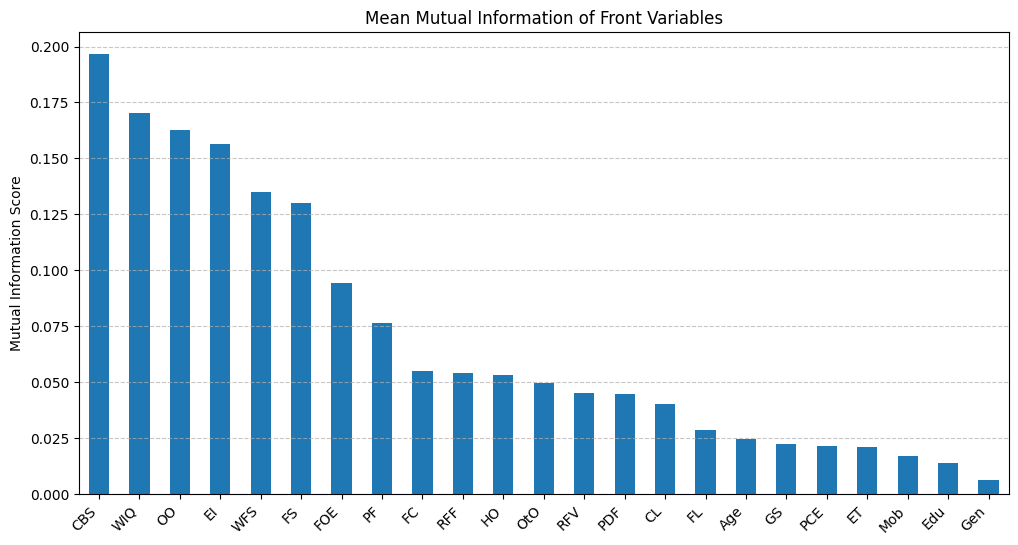

In [13]:
plt.figure(figsize=(12,6))
mi_df_sorted["Mean_MI"].plot(kind="bar", title="Mean Mutual Information of Front Variables")
plt.ylabel("Mutual Information Score")
plt.xticks(rotation=45, ha="right")  # 旋转X轴标签，避免重叠
plt.grid(axis="y", linestyle="--", alpha=0.7)  # 添加网格，提高可读性
plt.show()

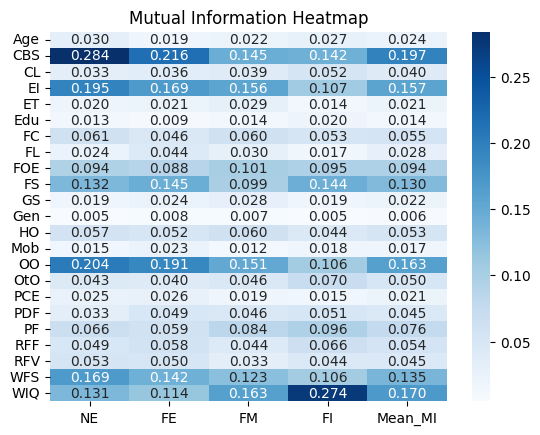

In [14]:
import seaborn as sns
sns.heatmap(mi_df, cmap="Blues", annot=True, fmt=".3f")
plt.title("Mutual Information Heatmap")
plt.show()
